In [124]:
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

In [125]:
om3 = [0.326, 0.447, 0.318, 0.481, 0.312, 0.304, 0.432, 0.461, 0.421, 0.423, 0.410, 0.447, 0.334, 0.487, 0.473, 0.368, 0.423, 0.493, 0.379, 0.424, 0.327, 0.475, 0.423, 0.445, 0.358, 0.387, 0.491, 0.396, 0.305, 0.352, 0.322, 0.381, 0.316, 0.488, 0.365, 0.371, 0.449, 0.337, 0.441, 0.349, 0.486, 0.370, 0.330, 0.488, 0.403, 0.426, 0.440, 0.356, 0.355, 0.467]

In [126]:
exps = [
    ["output_q=0.1_a=0.95_p=1_a_ratio=4_r_ratio=4"],
    ["output_q=0.1_a=0.95_p=1_a_ratio=4_r_ratio=4"],
]

exp_names = [
    "InfluxDB",
    "PostgreSQL"
]

labels = [
    ["VSCache", "M4"],
    ["VSCache", "M4"],
]

colors = {
    "VSCache": "seagreen",
    "M4" : "orange",
    "OM3" : "blue",
    "RAWCache" : "red",
}

datasets = [
    ["manufacturing_exp", "intel_lab_exp", "soccer_exp"],
    ["manufacturing_exp", "intel_lab_exp"]
]

comps = [
    ["m4-0.1"],
    ["m4-0.1"]
]

comp_results = [
    ["m4Results"],
    ["m4Results"]
]

m4 = [
    ["m4-0.1"],
]

dbs = [
    "influx",
    "postgres",
]

time_exps = [
    0, 1
]

figsize = (10,3)


In [127]:
dcts = [{
        'IO Count': 'mean',
        'Time (sec)': 'mean',
        'Query Time (sec)': 'mean',
        'Progressive Time (sec)': 'mean',
        'Memory': 'mean',
        'query #': 'mean',
        'width' : 'mean',
        'height' : 'mean',
        'timeRange': lambda col: col.mode() if col.nunique() == 1 else np.nan,
        'from': 'mean',
        'to': 'mean',
        'Results size': lambda col: col.mode() if col.nunique() == 1 else np.nan,
        'Error': lambda col: col.mode() if col.nunique() == 1 else np.nan,
        'dataset': lambda col: col.mode() if col.nunique() == 1 else np.nan,
        'operation': lambda col: col.mode() if col.nunique() == 1 else np.nan
    }, 
        {
        'Time (sec)': 'mean',
        'query #': 'mean',
        'width' : 'mean',
        'height' : 'mean',
        'from': 'mean',
        'to': 'mean',
        'timeRange': lambda col: col.mode() if col.nunique() == 1 else np.nan,
        'Results size': lambda col: col.mode() if col.nunique() == 1 else np.nan,
        'dataset': lambda col: col.mode() if col.nunique() == 1 else np.nan,
        'operation': lambda col: col.mode() if col.nunique() == 1 else np.nan
    },
    {
        'IO Count': 'mean',
        'Time (sec)': 'mean',
        'Memory': 'mean',
        'query #': 'mean',
        'width' : 'mean',
        'height' : 'mean',
        'from': 'mean',
        'to': 'mean',
        'timeRange': lambda col: col.mode() if col.nunique() == 1 else np.nan,
        'Results size': lambda col: col.mode() if col.nunique() == 1 else np.nan,
        'dataset': lambda col: col.mode() if col.nunique() == 1 else np.nan,
        'operation': lambda col: col.mode() if col.nunique() == 1 else np.nan
    }]

In [128]:
def get_experiment_dfs(exp_id):
    data = [f"{exp}/timeQueries/{dbs[exp_id]}/" for exp in exps[exp_id]]
    # names = os.listdir(os.path.join(data[0]))
    names = datasets[exp_id]
    if '.DS_Store' in names: names.remove('.DS_Store')
    runs = list(np.sort(os.listdir(os.path.join(data[0], names[0]))))
    if '.DS_Store' in runs: runs.remove('.DS_Store')
    results = ["ttiMinMaxResults"]
    results_paths = [os.path.join(d, name, run, result)  for name in names for d in data for result in results for run in runs  ]
    dfs_all = [pd.read_csv(os.path.join(df, "results.csv")) for df in results_paths]
    dfs = []
    for i in range(0, len(dfs_all), len(runs)):
        dds = dfs_all[i : i + len(runs)]
        d = dds[0]
        if(len(runs) > 1):
            for j in range(1, len(runs)):
                d = pd.concat((d, dds[j]))
            if("raw" in results_paths[i]):
                dct = dcts[2]
            elif("m4" in results_paths[i]):
                dct = dcts[1]
            else:
                dct = dcts[0]
            d = d.groupby(d.index).agg(**{k: (k, v) for k, v in dct.items()})
        dfs.append(d)
    return dfs, names


def get_competitor_dfs(exp_id):
    data = [f"{exp}/timeQueries/{dbs[exp_id]}/" for exp in comps[exp_id]]
    names = datasets[exp_id]
    if '.DS_Store' in names: names.remove('.DS_Store')
    runs = list(np.sort(os.listdir(os.path.join(data[0], names[0]))))
    if '.DS_Store' in runs: runs.remove('.DS_Store')
    results = comp_results[exp_id]
    results_paths = [os.path.join(d, name, run, result)  for name in names for d in data for result in results for run in runs]
    # for df in results_paths:
    #     print(df)
    #     pd.read_csv(os.path.join(df, "results.csv"))
    dfs_all = [pd.read_csv(os.path.join(df, "results.csv")) for df in results_paths]
    dfs = []
    for i in range(0, len(dfs_all), len(runs)):
        dds = dfs_all[i : i + len(runs)]
        d = dds[0]
        if(len(runs) > 1):
            for j in range(1, len(runs)):
                d = pd.concat((d, dds[j]))
            if("raw" in results_paths[i]):
                dct = dcts[2]
            elif("m4" in results_paths[i]):
                dct = dcts[1]
            else:
                dct = dcts[0]
            d = d.groupby(d.index).agg(**{k: (k, v) for k, v in dct.items()})
        d = d.rename(columns={'Time (sec)': 'Query Time (sec)'})
        dfs.append(d)
    return dfs, names

def reorder_list(lst, n):
    result = []
    for i, val in enumerate(zip(*[iter(lst)] * n)):
        result.extend(val)
    return result

def get_dfs(exp_id):
    dfs, names = get_experiment_dfs(exp_id)
    dfs_comps, _ = get_competitor_dfs(exp_id)
    dfs.extend(dfs_comps)
    dfs = sorted(dfs, key=lambda x: x['dataset'].iloc[0])
    return dfs, names

In [129]:

def reorder_list(lst):
    last_item = lst[-1]  # Get the last item
    lst.pop()  # Remove the last item
    lst.insert(1, last_item)  # Insert the last item at the second position
    return lst

def plot_time(dfs, exp_id):
    name = dfs[0]['dataset'][0]
    lbls = labels[exp_id]
    exp_name = exp_names[exp_id]

    plt.clf()
    sns.set(style="whitegrid")

    # Set a palette with more vibrant colors
    #palette = sns.color_palette("tab10", n_colors=len(lbls))
    palette = []
    for lbl in lbls:
        palette.append(colors[lbl])
    sns.set_palette(palette)

    fig, axs = plt.subplots(1, 2, figsize=figsize, gridspec_kw={'width_ratios': [3, 1]}, constrained_layout=True)

    times = []
    for i in range(len(lbls)):
        time = dfs[i]["Query Time (sec)"]
        times.append(time)
        sns.lineplot(data=time, ax=axs[0], label=lbls[i], linewidth=1, linestyle='-', alpha=0.8)  # Adjust line style and alpha as needed
    
    if(dfs[0]['dataset'][0] == 'manufacturing_exp' and dbs[exp_id] == 'postgres'):
        sns.lineplot(data=om3, ax=axs[0], color=colors['OM3'], label="OM3", linewidth=1, linestyle='-', alpha=0.8)  # Adjust line style and alpha as needed       
        times.append(np.array(om3))
        lbls.append("OM3")
        palette.append(colors["OM3"])
        lbls = reorder_list(lbls)
        palette = reorder_list(palette)
        times = reorder_list(times)


    #bar_patterns = ['//', '\\\\', 'xx', '||', '*']  # List of line patterns for the bar plots
    axs[0].get_legend().remove()

    
    mean_matrix = []
    sum_matrix = []
    x_positions = []
    length = len(lbls)
    for i in range(length):
        row1 = []
        row2 = []
        x_positions.append(i * (1 / length))
        for j in range(length):
            if i == j:
                row1.append(times[i].mean())
                row2.append(times[i].sum())
            else:
                row1.append(0)
                row2.append(0)
        mean_matrix.append(row1)
        sum_matrix.append(row2)

    for i in range(length):
        sns.barplot(x=x_positions, y=sum_matrix[i], ax=axs[1], color=palette[i], label=lbls[i],
                    #hatch=bar_patterns[i]
                   )  # Add hatch pattern to the bar plots
    axs[1].set_xticklabels([])
    #axs[2].set_xticklabels([])

    # Create a custom legend with boxes representing the patterns
    handles, _ = axs[1].get_legend_handles_labels()
    custom_legend = plt.legend(handles, lbls, bbox_to_anchor=(1, 0.6), frameon=False)
    
    plt.setp(custom_legend.get_title(), fontweight='bold')  # Set legend title font weight

    for ax in axs:
        ax.spines['top'].set_visible(False)  # Remove top border
        ax.spines['right'].set_visible(False)  # Remove right border

    # Set axis labels and font size
    axs[0].set_xlabel('Query', fontsize=12)
    axs[0].set_ylabel('Time (sec)', fontsize=12)
    #axs[1].set_ylabel('Average Time (sec)', fontsize=12)
    axs[1].set_ylabel('Cumulative Time (sec)', fontsize=12)

    # Adjust spacing and margins
    fig.subplots_adjust(bottom=0.2, wspace=0.3)  # Adjust the bottom margin and horizontal spacing
    plt.tight_layout()  # Adjust spacing and margins automatically

    # Save the plot as a PDF or other image format for high-quality output in the scientific paper
    plt.savefig(f'times/{exp_name}_{name}.png'.replace("%", ""), dpi=300)  # Adjust the filename and DPI as needed

    plt.show()
    
def plot_memory(dfs, name, exp_id):
    lbls = labels[exp_id]
    exp_name = exp_names[exp_id]
    plt.clf()
    sns.set(style="whitegrid")
    sns.set_palette("bright")  # Set the palette to "bright"
    
    fig, axs = plt.subplots(1, 2, figsize = figsize, gridspec_kw={'width_ratios': [3, 1]})
    fig.suptitle(f"Memory and average memory in {name} dataset for {exp}")
    sns.lineplot(data=dfs[0]['Memory'], label=labels[0], ax=axs[0])
    sns.lineplot(data=dfs[1]['Memory'], label=labels[1], ax=axs[0])

    bar_colors = sns.color_palette("bright")  # Get the colors from the palette
    x_positions = [0, 1]
    sns.barplot(x=x_positions, y=[dfs[0]["Memory"].mean(), 0], ax=axs[1], color=bar_colors[0], label=labels[0])
    sns.barplot(x=x_positions, y=[0, dfs[1]["Memory"].mean()], ax=axs[1], color=bar_colors[1], label=labels[2])
    axs[1].set_xticklabels([])

    handles, l = axs[0].get_legend_handles_labels()
    custom_legend = plt.legend(handles, l, loc=2, bbox_to_anchor=(0.9, 0.6))
    plt.show()
    
def plot_compaction(dfs, name, exp):
    plt.clf()
    sns.set(style="whitegrid")
    sns.set_palette("bright")  # Set the palette to "bright"
    
    fig, axs = plt.subplots(1, 2, figsize=figsize, gridspec_kw={'width_ratios': [3, 1]})
    fig.suptitle(f"Data Compaction in {name} dataset")

    dfs[0]["TTI Compaction"] = dfs[0]["Results size"]/dfs[1]["Results size"]
    dfs[2]["M4 Compaction"] = dfs[2]["Results size"]/dfs[2]["Results size"]
    bar_colors = sns.color_palette("bright")  # Get the colors from the palette

    sns.lineplot(data=dfs[0]['TTI Compaction'], label=labels[0], ax=axs[0])
    sns.lineplot(data=dfs[2]['M4 Compaction'], color=bar_colors[2], label=labels[2], ax=axs[0])

    x_positions = [0, 1]
    sns.barplot(x=x_positions, y=[dfs[0]["TTI Compaction"].mean(), 0], ax=axs[1], color=bar_colors[0], label=labels[0])
    sns.barplot(x=x_positions, y=[0, dfs[2]["M4 Compaction"].mean()], ax=axs[1], color=bar_colors[2], label=labels[2])
    axs[1].set_xticklabels([])
    
    handles, l = axs[1].get_legend_handles_labels()
    custom_legend = plt.legend(handles, l, loc=2, bbox_to_anchor=(0.9, 0.6))
    plt.show()
    

def plot_time_per_operation(dfs, name, exp_id):
    plt.clf()
    lbls = labels[exp_id]
    fig, axs = plt.subplots(1, len(dfs), figsize=(5*len(dfs), 5))
    fig.suptitle(f"Average time per operation in {name} dataset")

    operations = ['PAN', 'ZO', 'ZI']

    for i, df in enumerate(dfs):
        axs[i].set_title(f"Time per Operation type for {lbls[i]}")
        sns.boxplot(data=df, x='operation', y='Query Time (sec)', ax=axs[i])
    plt.tight_layout()
    plt.show()

/var/folders/cl/rlgfvqcj5bz8p2v_8qkjcb500000gn/T/ipykernel_10681/552581346.py:86: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(bottom=0.2, wspace=0.3)  # Adjust the bottom margin and horizontal spacing
/var/folders/cl/rlgfvqcj5bz8p2v_8qkjcb500000gn/T/ipykernel_10681/552581346.py:87: UserWarning: The figure layout has changed to tight
  plt.tight_layout()  # Adjust spacing and margins automatically


<Figure size 640x480 with 0 Axes>

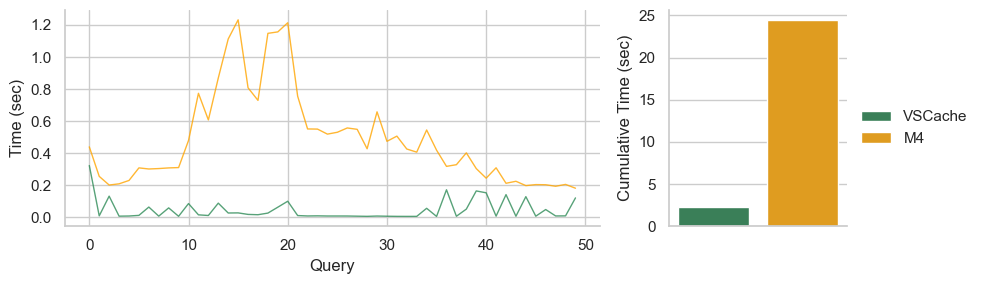

/var/folders/cl/rlgfvqcj5bz8p2v_8qkjcb500000gn/T/ipykernel_10681/552581346.py:86: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(bottom=0.2, wspace=0.3)  # Adjust the bottom margin and horizontal spacing
/var/folders/cl/rlgfvqcj5bz8p2v_8qkjcb500000gn/T/ipykernel_10681/552581346.py:87: UserWarning: The figure layout has changed to tight
  plt.tight_layout()  # Adjust spacing and margins automatically


<Figure size 640x480 with 0 Axes>

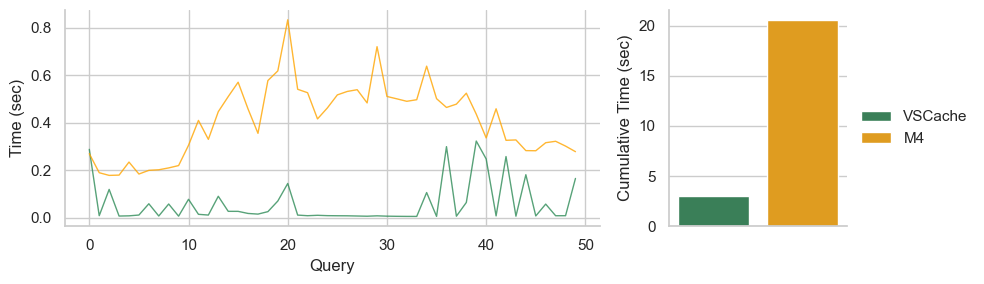

/var/folders/cl/rlgfvqcj5bz8p2v_8qkjcb500000gn/T/ipykernel_10681/552581346.py:86: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(bottom=0.2, wspace=0.3)  # Adjust the bottom margin and horizontal spacing
/var/folders/cl/rlgfvqcj5bz8p2v_8qkjcb500000gn/T/ipykernel_10681/552581346.py:87: UserWarning: The figure layout has changed to tight
  plt.tight_layout()  # Adjust spacing and margins automatically


<Figure size 640x480 with 0 Axes>

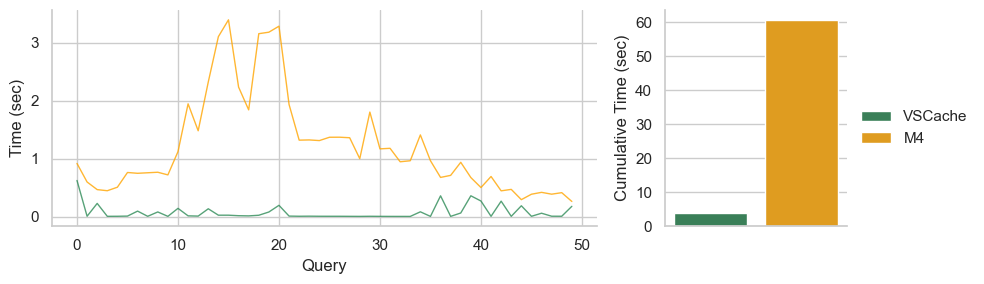

/var/folders/cl/rlgfvqcj5bz8p2v_8qkjcb500000gn/T/ipykernel_10681/552581346.py:86: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(bottom=0.2, wspace=0.3)  # Adjust the bottom margin and horizontal spacing
/var/folders/cl/rlgfvqcj5bz8p2v_8qkjcb500000gn/T/ipykernel_10681/552581346.py:87: UserWarning: The figure layout has changed to tight
  plt.tight_layout()  # Adjust spacing and margins automatically


<Figure size 640x480 with 0 Axes>

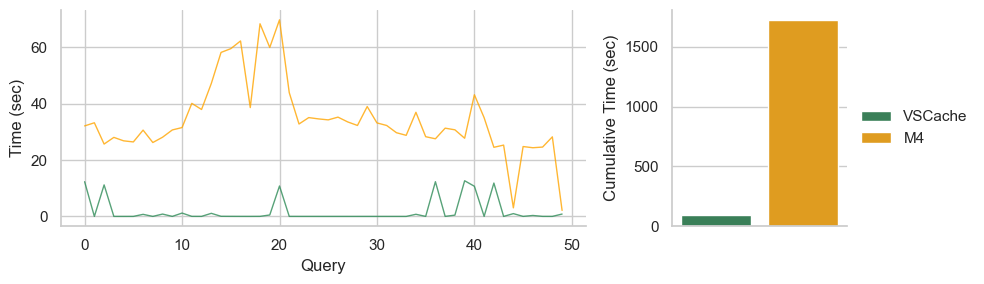

/var/folders/cl/rlgfvqcj5bz8p2v_8qkjcb500000gn/T/ipykernel_10681/552581346.py:86: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(bottom=0.2, wspace=0.3)  # Adjust the bottom margin and horizontal spacing
/var/folders/cl/rlgfvqcj5bz8p2v_8qkjcb500000gn/T/ipykernel_10681/552581346.py:87: UserWarning: The figure layout has changed to tight
  plt.tight_layout()  # Adjust spacing and margins automatically


<Figure size 640x480 with 0 Axes>

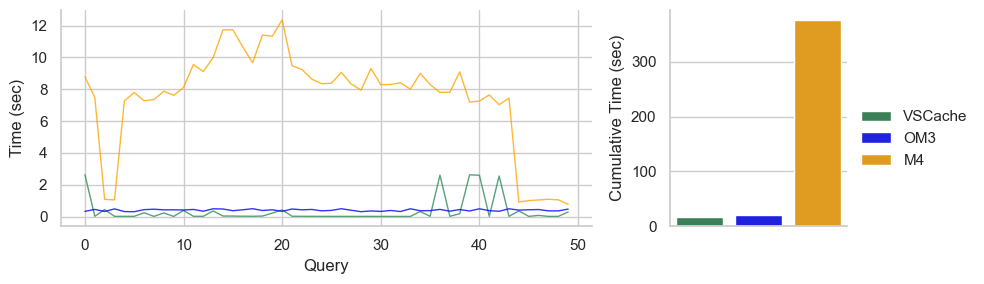

In [130]:
for exp_id in time_exps:
    j = 0
    dfs, names = get_dfs(exp_id)
    for i in range(0, len(dfs), len(labels[exp_id])):
        plot_time(dfs[i : i + len(labels[exp_id])], exp_id)
        j +=1

In [ ]:
for exp_id in memory_exps:
    j = 0
    dfs, names = get_dfs(exp_id)
    for i in range(0, len(dfs), len(labels[exp_id])):
        plot_memory(dfs[i : i + len(labels[exp_id])], names[j % len(names)], exp_id)
        j +=1